In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA, SparsePCA, NMF, ProjectedGradientNMF, LatentDirichletAllocation
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
import networkx as nx
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoLars, lasso_stability_path
from sklearn.cluster import KMeans
import random
from sklearn.svm import SVC

### Load Case-Centered Data into Pandas DF

In [2]:
trainX = pd.read_csv('../data/trainX_num_output.csv')
trainY = pd.read_csv('../data/trainY.csv')['partyWinning']
testX = pd.read_csv('../data/testX_num_output.csv')
testY = pd.read_csv('../data/testY.csv')['partyWinning']

### Feature Selection

Plot the stability of features. Note I don't actually select features in this way though.

In [3]:
labels = trainX.columns.values

Features sorted by their stability score using lasso stability paths:
(8577, 25)
(8577,)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.1s finished


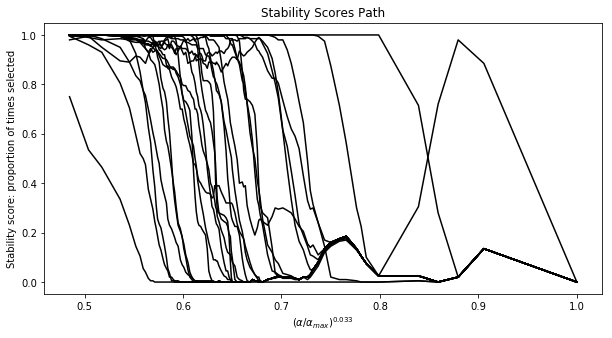

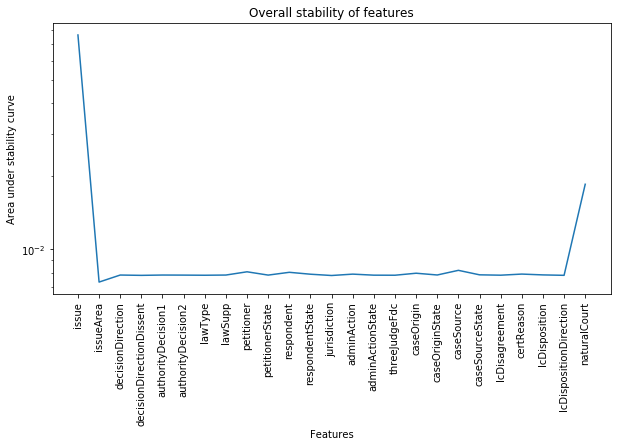

In [4]:
 def lasso_stability(trainX, Y, labels):
        ''''''
        print "Features sorted by their stability score using lasso stability paths:"
        print trainX.shape
        print Y.shape
        alpha_grid, scores_path = lasso_stability_path(trainX, Y, n_jobs = 1,
                                                       eps = 8.8817841970012523e-17, 
                                                       random_state=42, sample_fraction=0.75, verbose=True)
        
        plt.figure(num=1, figsize=(10, 5))
        #plot as a function of the alpha/alpha_max
        variables = plt.plot(alpha_grid[1:] ** 0.0333, scores_path.T[1:], 'k')
        ymin, ymax = plt.ylim()
        plt.xlabel(r'$(\alpha / \alpha_{max})^{0.033}$')
        plt.ylabel('Stability score: proportion of times selected')
        plt.title('Stability Scores Path')
        plt.axis('tight')
        
        plt.figure(num=2, figsize=(10, 5))
        auc = (scores_path.dot(alpha_grid))
        auc_plot = plt.plot((scores_path.dot(alpha_grid)))
        plt.xlabel(r'Features')
        plt.ylabel(r'Area under stability curve')
        plt.title('Overall stability of features')
        plt.yscale('log')
        x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
        plt.show()
        
labels = trainX.columns.values        
lasso_stability(trainX.values, trainY.values, labels)

In [5]:
""" Get DataFrame of feature names using different types of feature selection. """
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE

skb = SelectKBest(chi2, k=10)
X_new = skb.fit_transform(trainX, trainY)

### Classify

In [6]:
# testX[pd.DataFrame(X_new).columns]

In [7]:
rnb = RandomForestClassifier()
rnb.fit(trainX, trainY)

knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
knn.fit(trainX, trainY)

gnb = GaussianNB()
gnb.fit(trainX, trainY)

# mnb = MultinomialNB()
# mnb.fit(trainX, trainY['partyWinning'])

bnb = BernoulliNB()
bnb.fit(trainX, trainY)

dt = DecisionTreeClassifier()
dt.fit(trainX, trainY)

# svc = SVC(kernel='linear')
# svc.fit(trainX, trainY)

log_reg = LogisticRegression()
log_reg.fit(trainX, trainY)

log_reg_l1 = LogisticRegression(penalty='l1')
log_reg_l1.fit(trainX, trainY)

lr = LinearRegression()
lr.fit(trainX, trainY)

ridge = Ridge(alpha=0.5)
ridge.fit(trainX, trainY)

lasso = Lasso(alpha=0.1)
lasso.fit(trainX, trainY)

lasso_lars = LassoLars(alpha=.2)
lasso_lars.fit(trainX, trainY)


LassoLars(alpha=0.2, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)

### with feature selection

In [8]:
rnb_fs = RandomForestClassifier()
rnb_fs.fit(X_new, trainY)

knn_fs = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
knn_fs.fit(X_new, trainY)

gnb_fs = GaussianNB()
gnb_fs.fit(X_new, trainY)

# mnb = MultinomialNB()
# mnb.fit(trainX, trainY['partyWinning'])

bnb_fs = BernoulliNB()
bnb_fs.fit(X_new, trainY)

dt_fs = DecisionTreeClassifier()
dt_fs.fit(X_new, trainY)

# svc = SVC(kernel='linear')
# svc.fit(trainX, trainY)

log_reg_fs = LogisticRegression()
log_reg_fs.fit(X_new, trainY)

log_reg_l1_fs = LogisticRegression(penalty='l1')
log_reg_l1_fs.fit(X_new, trainY)

lr_fs = LinearRegression()
lr_fs.fit(X_new, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
ridge_fs = Ridge(alpha=0.5)
ridge_fs.fit(X_new, trainY)

lasso_fs = Lasso(alpha=0.1)
lasso_fs.fit(X_new, trainY)

lasso_lars_fs = LassoLars(alpha=.2)
lasso_lars_fs.fit(X_new, trainY)

LassoLars(alpha=0.2, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False)

### results without feature selection

In [10]:
y_pred = rnb.predict(testX)

print("RNB")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = knn.predict(testX)

print("KNN")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = gnb.predict(testX)

print("GNB")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = bnb.predict(testX)

print("BNB")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = dt.predict(testX)

print("DT")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

RNB
accuracy: 0.854166666667
precision: 0.852641600118
recall: 0.854166666667
f1: 0.852997454777
KNN
accuracy: 0.513888888889
precision: 0.503900112233
recall: 0.513888888889
f1: 0.508557554045
GNB
accuracy: 0.625
precision: 0.635478670635
recall: 0.625
f1: 0.608994276988
BNB
accuracy: 0.638888888889
precision: 0.433531746032
recall: 0.638888888889
f1: 0.516548463357
DT
accuracy: 0.743055555556
precision: 0.7361791939
recall: 0.743055555556
f1: 0.737738079743


/home/whinthorn/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/whinthorn/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### results with feature selection

In [11]:
testX_fs = testX[pd.DataFrame(X_new).columns]

y_pred = rnb_fs.predict(testX_fs)

print("RNB")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = knn_fs.predict(testX_fs)

print("KNN")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = gnb_fs.predict(testX_fs)

print("GNB")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = bnb_fs.predict(testX_fs)

print("BNB")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

y_pred = dt_fs.predict(testX_fs)

print("DT")
print("accuracy: " + str(accuracy_score(testY,y_pred)))
print("precision: " + str(precision_score(testY,y_pred, average='weighted')))
print("recall: " + str(recall_score(testY,y_pred, average='weighted')))
print("f1: " + str(f1_score(testY,y_pred, average='weighted')))

RNB
accuracy: 0.555555555556
precision: 0.541893724256
recall: 0.555555555556
f1: 0.547865523021
KNN
accuracy: 0.604166666667
precision: 0.564583333333
recall: 0.604166666667
f1: 0.574558879939
GNB
accuracy: 0.597222222222
precision: 0.563552188552
recall: 0.597222222222
f1: 0.573568684716
BNB
accuracy: 0.416666666667
precision: 0.498189936894
recall: 0.416666666667
f1: 0.428803016508
DT
accuracy: 0.555555555556
precision: 0.59017634967
recall: 0.555555555556
f1: 0.566310412045


### without fs

In [12]:
y_pred = log_reg.predict(testX)

print("Log reg")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = lr.predict(testX)
print("LR")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = log_reg_l1.predict(testX)
print("log reg l1")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = ridge.predict(testX)
print("ridge")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = lasso.predict(testX)
print("Lasso")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = lasso_lars.predict(testX)
print("LassoLars")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

Log reg
RMSE: 0.354166666667
R^2: -0.577658431794
LR
RMSE: 0.221540913623
R^2: 0.0131316036745
log reg l1
RMSE: 0.3125
R^2: -0.392051557465
ridge
RMSE: 0.221520395671
R^2: 0.0132230022282
Lasso
RMSE: 0.21986915586
R^2: 0.0205785572691
LassoLars
RMSE: 0.224911977928
R^2: -0.00188502133374


### with fs

In [13]:
testX_fs = testX[pd.DataFrame(X_new).columns]

y_pred = log_reg_fs.predict(testX_fs)

print("Log reg")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = lr_fs.predict(testX_fs)
print("LR")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = log_reg_l1_fs.predict(testX_fs)
print("log reg l1")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = ridge_fs.predict(testX_fs)
print("ridge")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = lasso_fs.predict(testX_fs)
print("Lasso")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

y_pred = lasso_lars_fs.predict(testX_fs)
print("LassoLars")
print("RMSE: " + str(mean_squared_error(testY, y_pred)))
print("R^2: " + str(r2_score(testY, y_pred)))

Log reg
RMSE: 0.340277777778
R^2: -0.515789473684
LR
RMSE: 4.58348670136
R^2: -19.417439364
log reg l1
RMSE: 0.340277777778
R^2: -0.515789473684
ridge
RMSE: 4.60038439147
R^2: -19.4927112227
Lasso
RMSE: 1.27991296837
R^2: -4.70145549134
LassoLars
RMSE: 0.224911977928
R^2: -0.00188502133374


### ROC Curves for Classifiers

In [14]:
classifiers = [gnb, rnb, knn, bnb, dt]
clf_labels = {gnb: "gnb",rnb: "rnb",knn: "knn",bnb: "bnb",dt: "dt"}

def plot_ROC(fpr, tpr, roc_auc, l):
    label_end = ': AUC = %0.5f' % roc_auc
    label = l + label_end
    lw = 2
    r = lambda: random.randint(0, 255)
    c = '#%02X%02X%02X' % (r(),r(),r())
    plt.plot(fpr, tpr, color=c,
             lw=lw, label=label)


# def calcROC(clf, test_feature, test_class, label):
#     predict_probas = clf.predict_proba(test_feature)[:,1]
#     fpr, tpr, _ = roc_curve(test_class, predict_probas)
#     roc_auc = auc(fpr, tpr)
#     # lb = 'BOW-NB' + label
#     plot_ROC(fpr, tpr, roc_auc, label)

def calcROC(clf, X, y_true):
    y_pred = clf.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    # lb = 'BOW-NB' + label
    plot_ROC(fpr, tpr, roc_auc, clf_labels[clf])

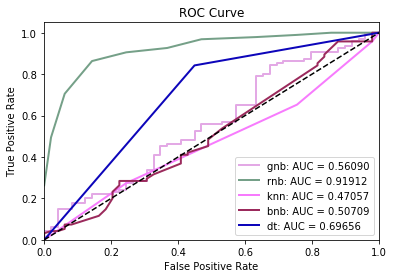

In [15]:
for clf in classifiers:
    y_true = testY
    calcROC(clf, testX, y_true)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()